In [1]:
import numpy as np
import torch

In [2]:
from models.SimpleLinearPFN import SimpleLinearPFN

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
import sys
import os

# Go up one level to project root
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)

In [5]:
model = SimpleLinearPFN(L=36, H=36, d=512, L_blk=12,
                              n_heads=16, d_ff=2048, dropout=0.1)
checkpoint = torch.load("ckpts/36_36/best_model.pt", weights_only=False)['model_state_dict']
model.load_state_dict(checkpoint)
model.to(device)

/home/lvu/playground/ts-project/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


SimpleLinearPFN(
  (phi_ctx): Linear(in_features=72, out_features=512, bias=True)
  (phi_qry): Linear(in_features=72, out_features=512, bias=True)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-11): 12 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (output_head): Linear(in_features=512, out_features=72, bias=True)
)

In [6]:
# Test meta-learning model using standard dataloaders with train_budget
from data_provider.data_factory import data_provider
import torch

# Create arguments object for ECL dataset
class Args:
    def __init__(self):
        self.root_path = '../../ForecastPFN/academic_data/illness/'
        self.data_path = 'national_illness.csv'
        self.data = 'ili'
        self.features = 'S'
        self.target = 'OT'
        self.freq = 'h'
        self.embed = 'timeF'
        
        self.seq_len = 36    # L: matches model L=36
        self.label_len = 25  
        self.pred_len = 36   # H: matches model H=20
        
        self.train_budget = 100  # Handled by Dataset_Custom
        
        self.model = 'iTransformer'
        self.model_id = 'ECL_meta'
        self.batch_size = 32
        self.num_workers = 4
        self.seasonal_patterns = None

args = Args()

print("Loading dataloaders...")

# Load data with train_budget handled automatically
train_data, train_loader = data_provider(args, 'train')
test_data, test_loader = data_provider(args, 'test')

print(f"Train dataset length: {len(train_data)} (limited by train_budget={args.train_budget})")
print(f"Test dataset length: {len(test_data)}")

# Collect context examples from training data
context_x, context_y = [], []

for batch_x, batch_y, _, _ in train_loader:
    for i in range(batch_x.shape[0]):
        context_x.append(batch_x[i])
        context_y.append(batch_y[i, -36:])

ctx_x = torch.stack(context_x)  # [num_context, seq_len, features]
ctx_z = torch.stack(context_y)  # [num_context, pred_len, features]

print(f"Context data shape: {ctx_x.shape}")

# Get query from test data
test_iter = iter(test_loader)
batch_x, batch_y, _, _ = next(test_iter)

qry_x = batch_x[0:1]  # [1, seq_len, features]
qry_z = batch_y[0:1, -36:]  # [1, pred_len, features]

print(f"Query shapes: {qry_x.shape}")

# Test model
model.eval()
with torch.no_grad():
    # For univariate model, select only the target feature or average features
    if ctx_x.shape[-1] > 1:  # If multivariate
        ctx_x_model = ctx_x[..., 0]
        ctx_z_model = ctx_z[..., 0]
        qry_x_model = qry_x[..., 0]
        qry_z_target = qry_z[..., 0]
    else:
        ctx_x_model = ctx_x.squeeze(-1)
        ctx_z_model = ctx_z.squeeze(-1)
        qry_x_model = qry_x.squeeze(-1)
        qry_z_target = qry_z.squeeze(-1)

    ctx_x_batch = ctx_x_model.unsqueeze(0).float().to(device)  # [1, num_context, seq_len]
    ctx_z_batch = ctx_z_model.unsqueeze(0).float().to(device)  # [1, num_context, pred_len]
    qry_x_batch = qry_x_model.unsqueeze(0).float().to(device)  # [1, 1, seq_len]

    print(f"Model input shapes:")
    print(f"  ctx_x: {ctx_x_batch.shape}")
    print(f"  ctx_z: {ctx_z_batch.shape}")
    print(f"  qry_x: {qry_x_batch.shape}")
    
    # Now call the model
    model_output = model(ctx_x_batch, ctx_z_batch, qry_x_batch)
    print(f"Model output type: {type(model_output)}")
    
    if isinstance(model_output, tuple):
        print(f"Model returns tuple with {len(model_output)} elements")
        mu, log_sigma2 = model_output
    else:
        print(f"Model returns single tensor with shape: {model_output.shape}")
        mu = model_output
        log_sigma2 = torch.zeros_like(mu)
    
    print(f"Output shapes:")
    print(f"  mu: {mu.shape}")
    print(f"  log_sigma2: {log_sigma2.shape}")
    
    # For comparison, also take first feature of target
    # qry_z_target = qry_z_model[-args.pred_len:]  # Last pred_len values
    mse = torch.nn.functional.mse_loss(mu.squeeze(), qry_z_target.to(device))
    print(f"MSE: {mse.item():.6f}")

Loading dataloaders...
train 65
test 158
Train dataset length: 65 (limited by train_budget=100)
Test dataset length: 158
Context data shape: torch.Size([65, 36, 1])
Query shapes: torch.Size([1, 36, 1])
Model input shapes:
  ctx_x: torch.Size([1, 65, 36])
  ctx_z: torch.Size([1, 65, 36])
  qry_x: torch.Size([1, 1, 36])
Model output type: <class 'tuple'>
Model returns tuple with 2 elements
Output shapes:
  mu: torch.Size([1, 1, 36])
  log_sigma2: torch.Size([1, 1, 36])
MSE: 2.116932


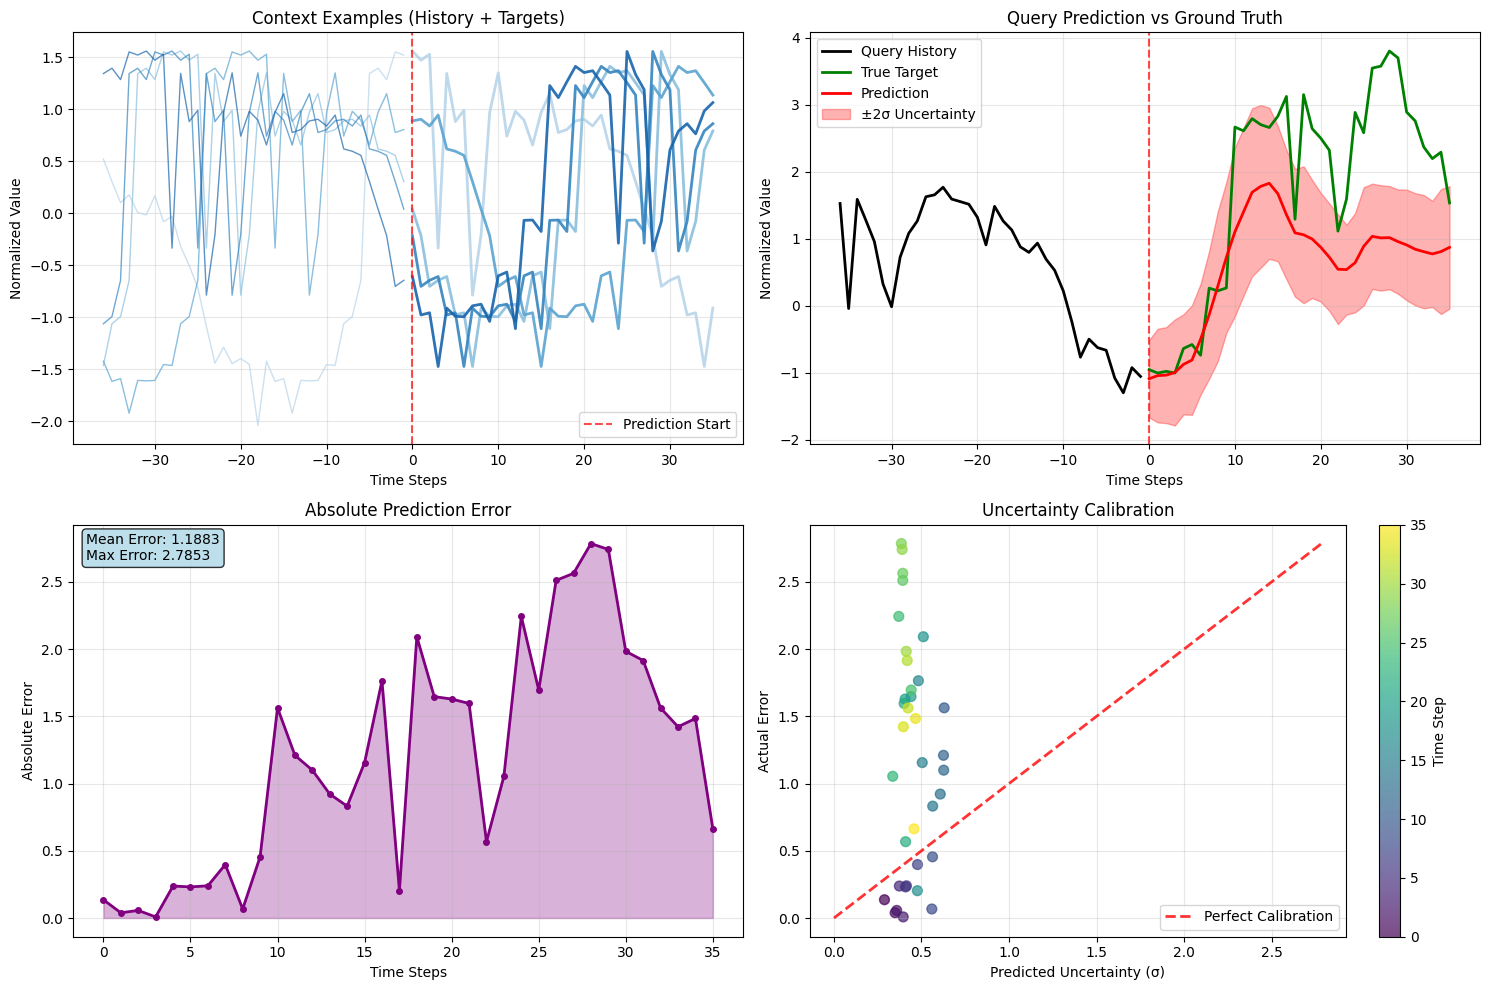


PREDICTION ANALYSIS

Data Statistics:
  Context examples: 65
  Sequence length: 36
  Prediction horizon: 36

Prediction Performance:
  MSE: 2.116932
  RMSE: 1.454968
  MAE: 1.188267
  Max Error: 2.785283
  Correlation: 0.8799

Uncertainty Analysis:
  Mean predicted σ: 0.448645
  σ range: [0.288408, 0.629538]
  Points within 1σ: 30.6% (should be ~68%)
  Points within 2σ: 47.2% (should be ~95%)

Target Statistics:
  Target range: [-1.0076, 3.7988]
  Target std: 1.5635
  Target mean: 1.7467


In [9]:
import matplotlib.pyplot as plt

# Visualize the data and predictions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Context examples visualization
ax1 = axes[0, 0]
n_context_show = min(5, ctx_x_model.shape[0])
colors = plt.cm.Blues(np.linspace(0.3, 0.8, n_context_show))

for i in range(n_context_show):
    # Show history
    hist_steps = np.arange(-args.seq_len, 0)
    ax1.plot(hist_steps, ctx_x_model[i].cpu(), color=colors[i], alpha=0.7, linewidth=1)
    
    # Show targets
    pred_steps = np.arange(0, args.pred_len)
    ax1.plot(pred_steps, ctx_z_model[i].cpu(), color=colors[i], alpha=0.9, linewidth=2)

ax1.axvline(0, color='red', linestyle='--', alpha=0.7, label='Prediction Start')
ax1.set_title('Context Examples (History + Targets)')
ax1.set_xlabel('Time Steps')
ax1.set_ylabel('Normalized Value')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Query example with prediction
ax2 = axes[0, 1]

# Query history - fix the dimension issue
hist_steps = np.arange(-args.seq_len, 0)
ax2.plot(hist_steps, qry_x_model.squeeze().cpu(), 'k-', linewidth=2, label='Query History')

# True target
pred_steps = np.arange(0, args.pred_len)
ax2.plot(pred_steps, qry_z_target.squeeze().cpu(), 'g-', linewidth=2, label='True Target')

# Model prediction
mu_cpu = mu.squeeze().cpu()
log_sigma2_cpu = log_sigma2.squeeze().cpu()
sigma_cpu = torch.exp(0.5 * log_sigma2_cpu)

ax2.plot(pred_steps, mu_cpu, 'r-', linewidth=2, label='Prediction')
ax2.fill_between(pred_steps, 
                 mu_cpu - 2*sigma_cpu, 
                 mu_cpu + 2*sigma_cpu, 
                 alpha=0.3, color='red', label='±2σ Uncertainty')

ax2.axvline(0, color='red', linestyle='--', alpha=0.7)
ax2.set_title('Query Prediction vs Ground Truth')
ax2.set_xlabel('Time Steps')
ax2.set_ylabel('Normalized Value')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Prediction error analysis
ax3 = axes[1, 0]
errors = torch.abs(mu_cpu - qry_z_target.squeeze().cpu())
ax3.plot(pred_steps, errors, 'purple', linewidth=2, marker='o', markersize=4)
ax3.fill_between(pred_steps, 0, errors, alpha=0.3, color='purple')
ax3.set_title('Absolute Prediction Error')
ax3.set_xlabel('Time Steps')
ax3.set_ylabel('Absolute Error')
ax3.grid(True, alpha=0.3)

# Add error statistics
mean_error = errors.mean().item()
max_error = errors.max().item()
ax3.text(0.02, 0.98, f'Mean Error: {mean_error:.4f}\nMax Error: {max_error:.4f}', 
         transform=ax3.transAxes, verticalalignment='top',
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.8))

# 4. Uncertainty vs Error scatter plot
ax4 = axes[1, 1]
scatter = ax4.scatter(sigma_cpu, errors, alpha=0.7, s=50, c=pred_steps, cmap='viridis')
ax4.plot([0, max(sigma_cpu.max(), errors.max())], [0, max(sigma_cpu.max(), errors.max())], 
         'r--', alpha=0.8, linewidth=2, label='Perfect Calibration')

ax4.set_xlabel('Predicted Uncertainty (σ)')
ax4.set_ylabel('Actual Error')
ax4.set_title('Uncertainty Calibration')
ax4.legend()
ax4.grid(True, alpha=0.3)

# Add colorbar for time steps
cbar = plt.colorbar(scatter, ax=ax4)
cbar.set_label('Time Step')

plt.tight_layout()
plt.show()

# Print detailed statistics
print("\n" + "="*50)
print("PREDICTION ANALYSIS")
print("="*50)

print(f"\nData Statistics:")
print(f"  Context examples: {ctx_x_model.shape[0]}")
print(f"  Sequence length: {args.seq_len}")
print(f"  Prediction horizon: {args.pred_len}")

print(f"\nPrediction Performance:")
print(f"  MSE: {mse.item():.6f}")
print(f"  RMSE: {torch.sqrt(mse).item():.6f}")
print(f"  MAE: {errors.mean().item():.6f}")
print(f"  Max Error: {errors.max().item():.6f}")

# Correlation between prediction and target
correlation = torch.corrcoef(torch.stack([mu_cpu, qry_z_target.squeeze().cpu()]))[0, 1]
print(f"  Correlation: {correlation.item():.4f}")

print(f"\nUncertainty Analysis:")
print(f"  Mean predicted σ: {sigma_cpu.mean().item():.6f}")
print(f"  σ range: [{sigma_cpu.min().item():.6f}, {sigma_cpu.max().item():.6f}]")

# Check calibration (roughly)
within_1sigma = (errors <= sigma_cpu).float().mean()
within_2sigma = (errors <= 2*sigma_cpu).float().mean()
print(f"  Points within 1σ: {within_1sigma.item():.1%} (should be ~68%)")
print(f"  Points within 2σ: {within_2sigma.item():.1%} (should be ~95%)")

print(f"\nTarget Statistics:")
qry_z_flat = qry_z_target.squeeze().cpu()
print(f"  Target range: [{qry_z_flat.min().item():.4f}, {qry_z_flat.max().item():.4f}]")
print(f"  Target std: {qry_z_flat.std().item():.4f}")
print(f"  Target mean: {qry_z_flat.mean().item():.4f}")

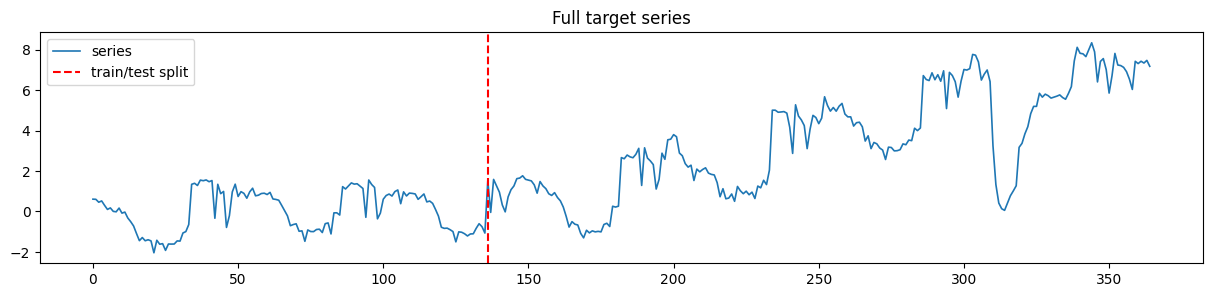

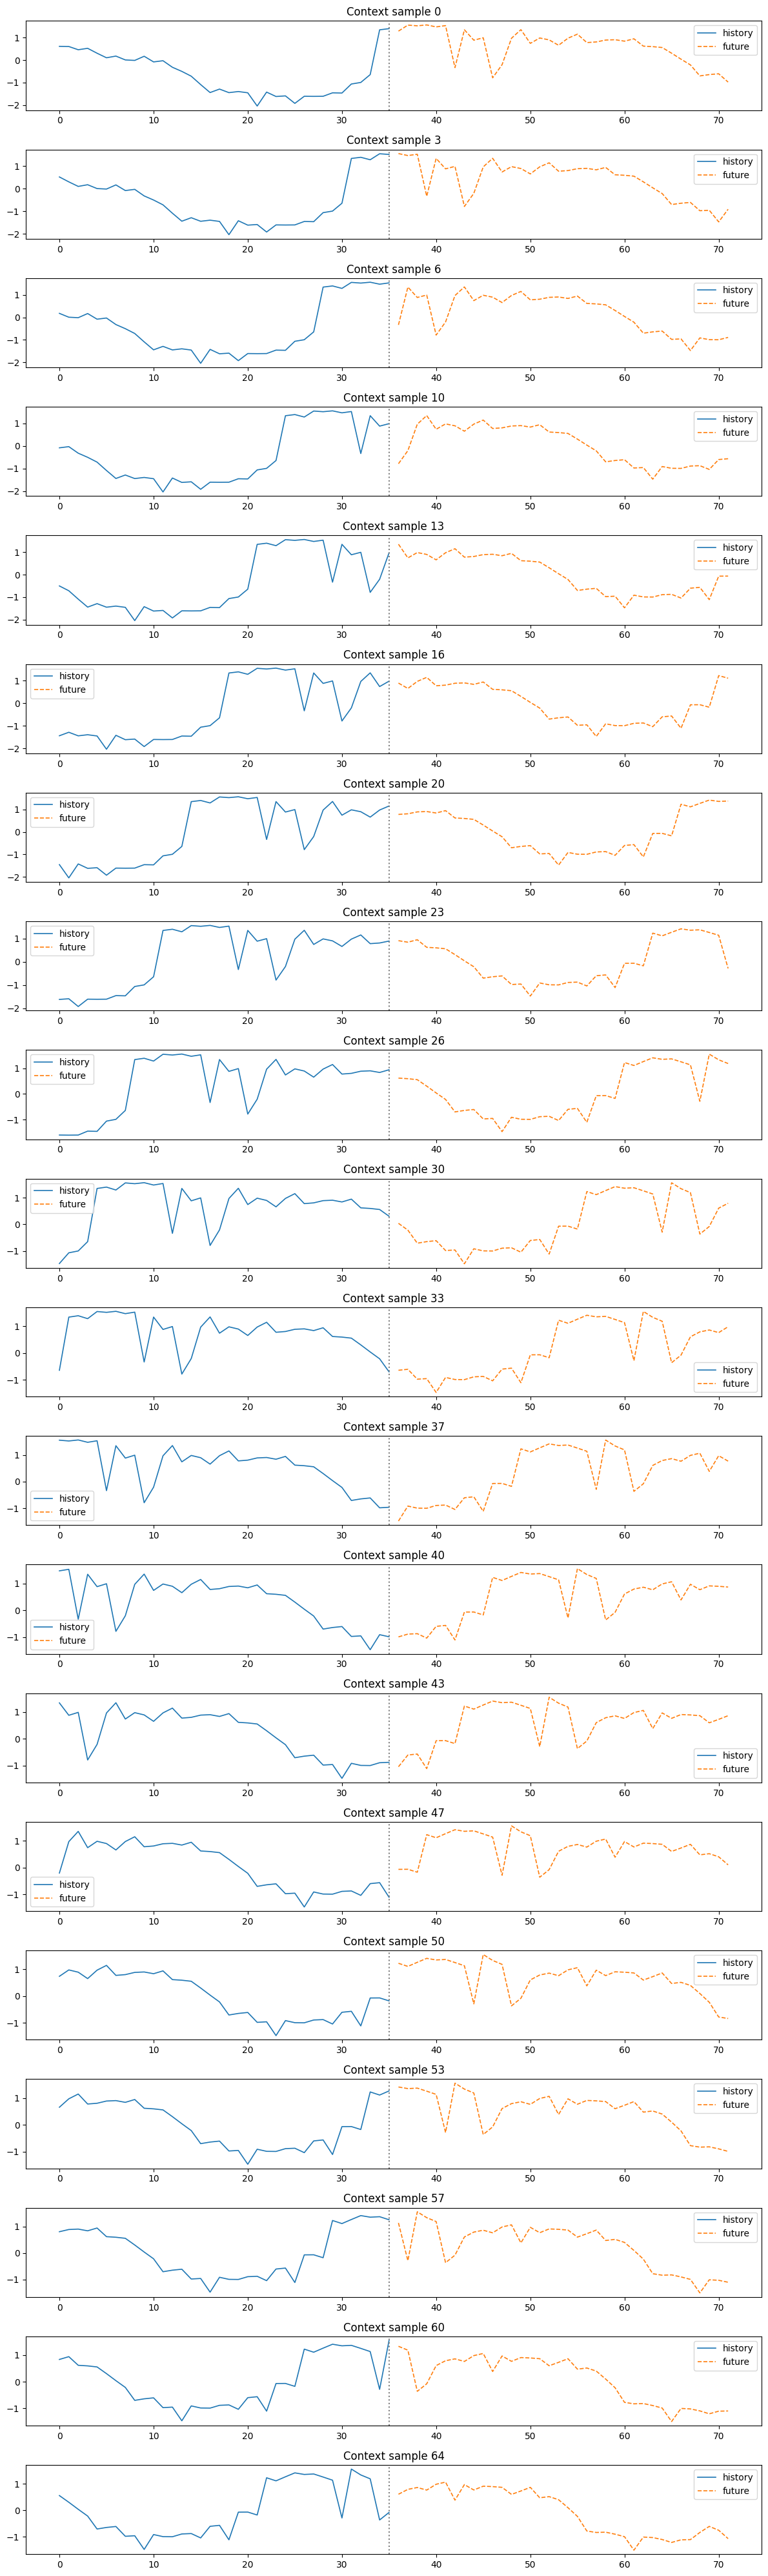

In [12]:
def to_np(x):
    return x.detach().cpu().numpy() if isinstance(x, torch.Tensor) else np.asarray(x)

def get_patch(ds, idx, pred_len):
    seq_x, seq_y = ds[idx][:2]
    seq_x = to_np(seq_x); seq_y = to_np(seq_y)
    hist  = seq_x[:, 0] if seq_x.ndim == 2 else seq_x
    fut   = seq_y[-pred_len:, 0] if seq_y.ndim == 2 else seq_y[-pred_len:]
    return hist, fut

# --- 1) Full dataset ---
y_train = to_np(train_data.data_y).squeeze()
y_test  = to_np(test_data.data_y).squeeze()

full = np.concatenate([y_train, y_test])
split_idx = len(y_train)

plt.figure(figsize=(15,3))
plt.plot(full, lw=1.2, label="series")
plt.axvline(split_idx, ls="--", c="red", label="train/test split")
plt.title("Full target series")
plt.legend(); plt.show()

# --- 2) Context samples ---
num_ctx = min(20, len(train_data))
ctx_indices = np.linspace(0, len(train_data)-1, num_ctx, dtype=int)

fig, axes = plt.subplots(num_ctx, 1, figsize=(12, 2*num_ctx), sharex=False)
if num_ctx == 1: axes = [axes]

for ax, idx in zip(axes, ctx_indices):
    hist, fut = get_patch(train_data, idx, args.pred_len)
    t_hist = np.arange(len(hist))
    t_fut  = np.arange(len(hist), len(hist)+len(fut))
    ax.plot(t_hist, hist, lw=1.2, label="history")
    ax.plot(t_fut, fut, ls="--", lw=1.2, label="future")
    ax.axvline(len(hist)-1, ls=":", c="gray")
    ax.set_title(f"Context sample {idx}")
    ax.legend()

plt.tight_layout(); plt.show()

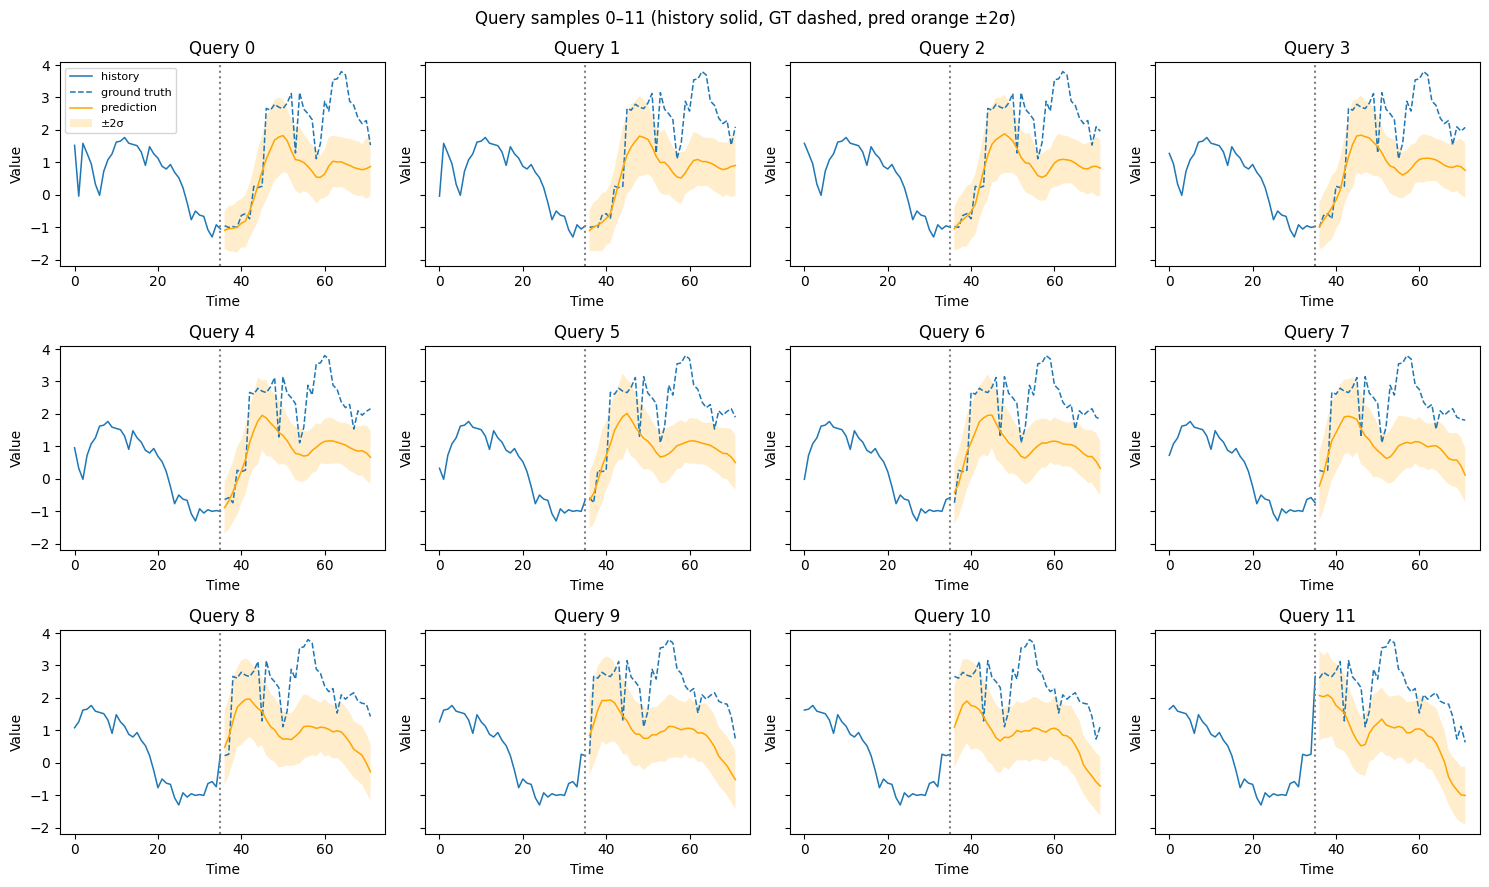

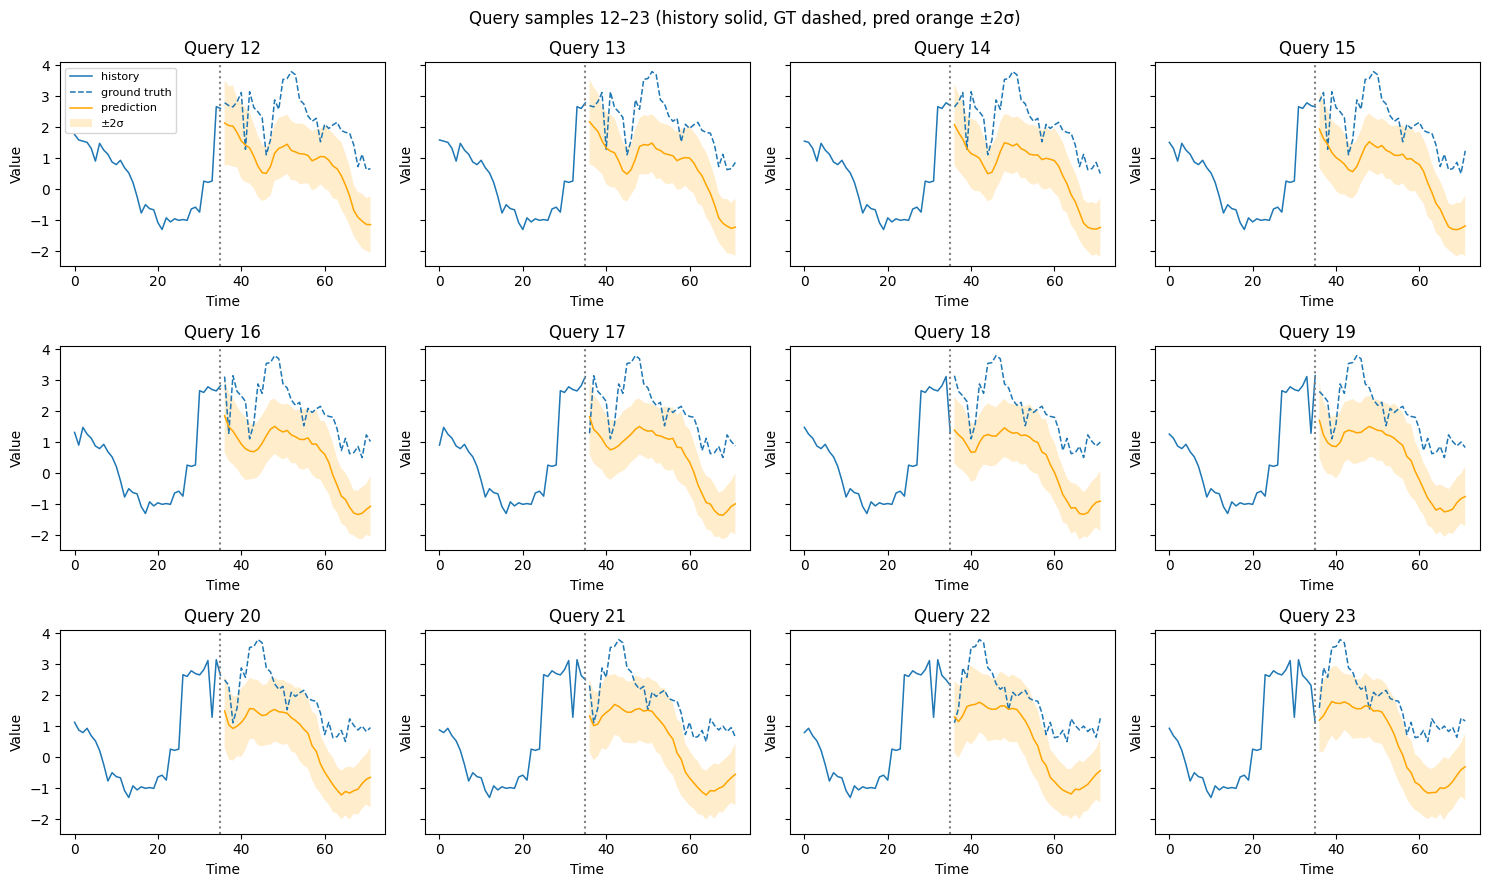

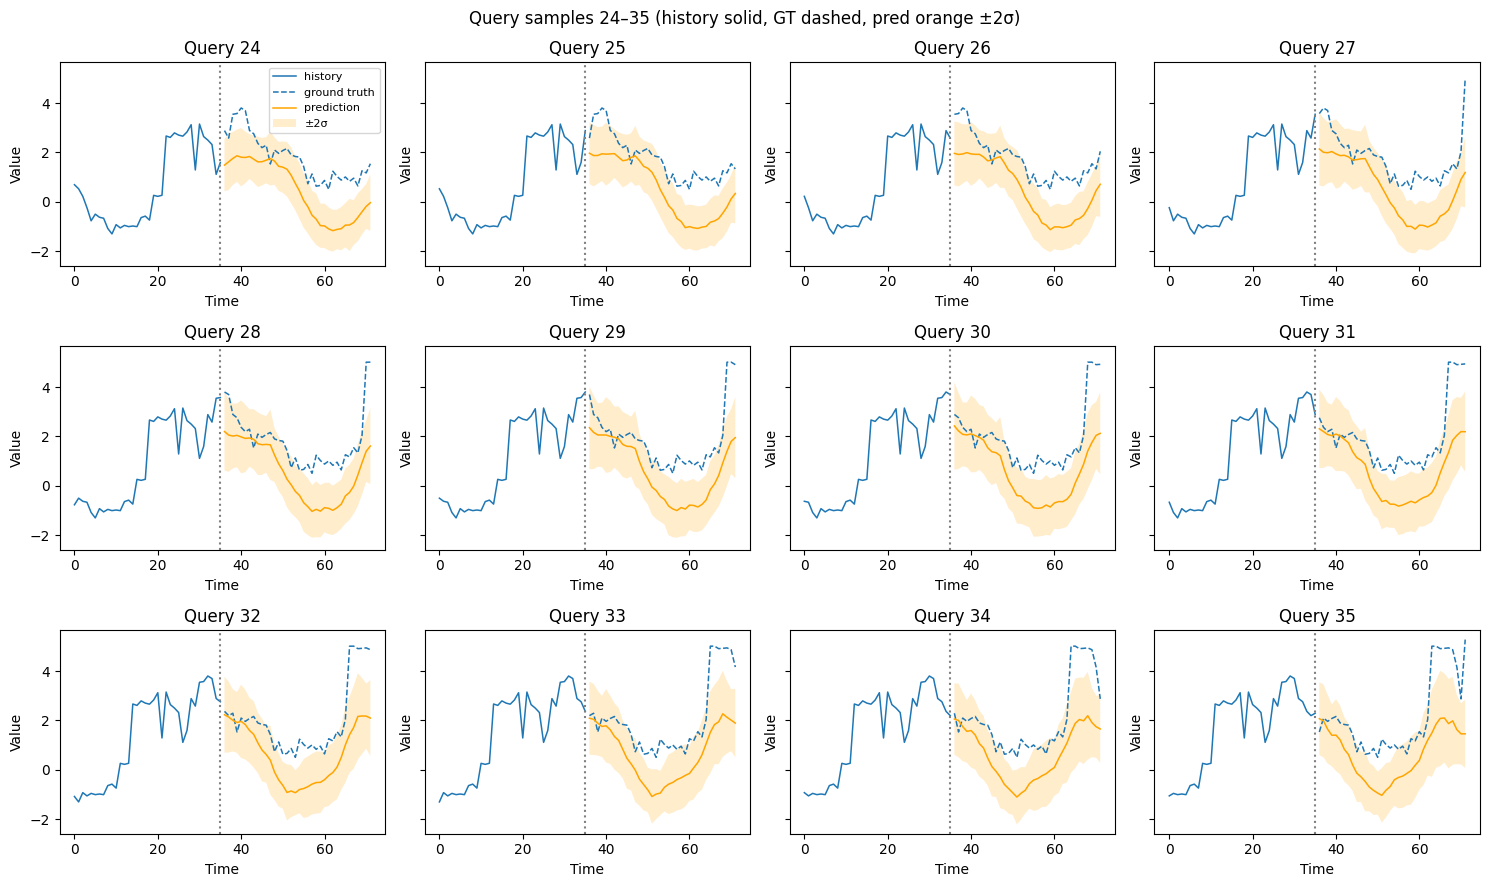

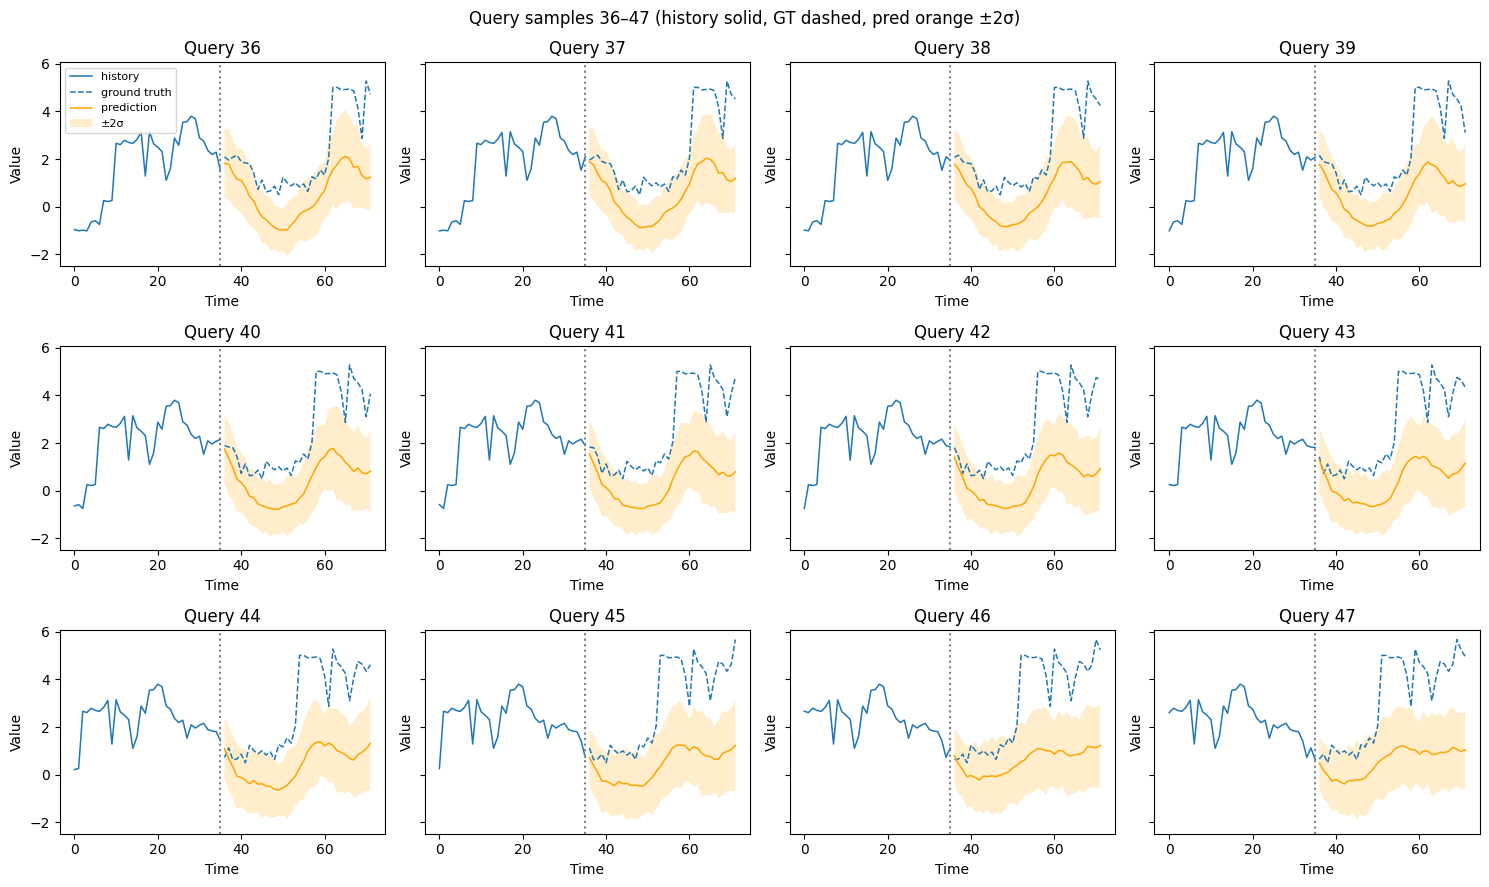

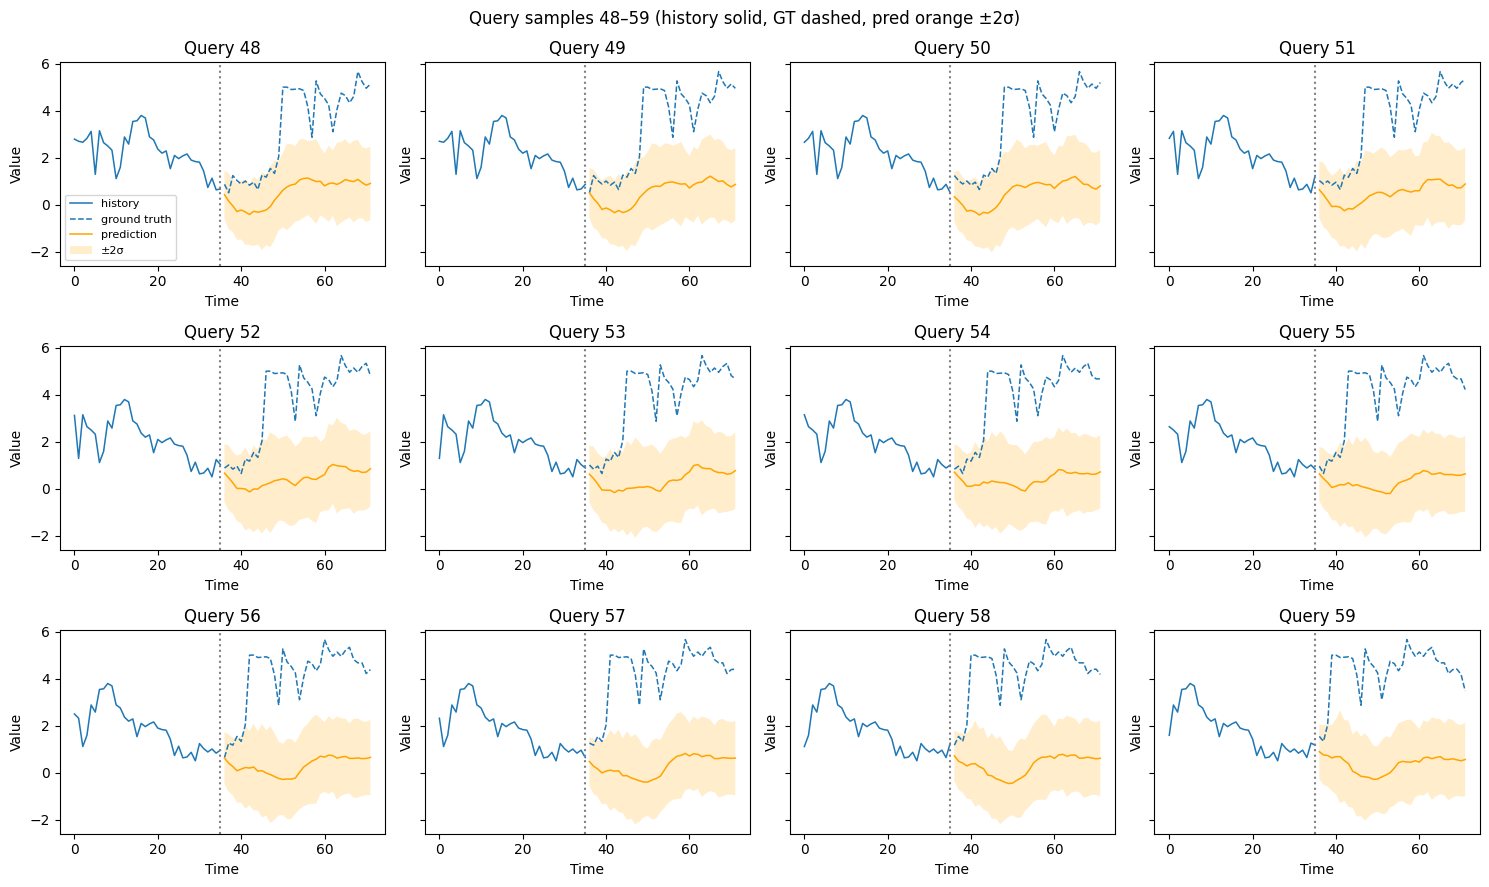

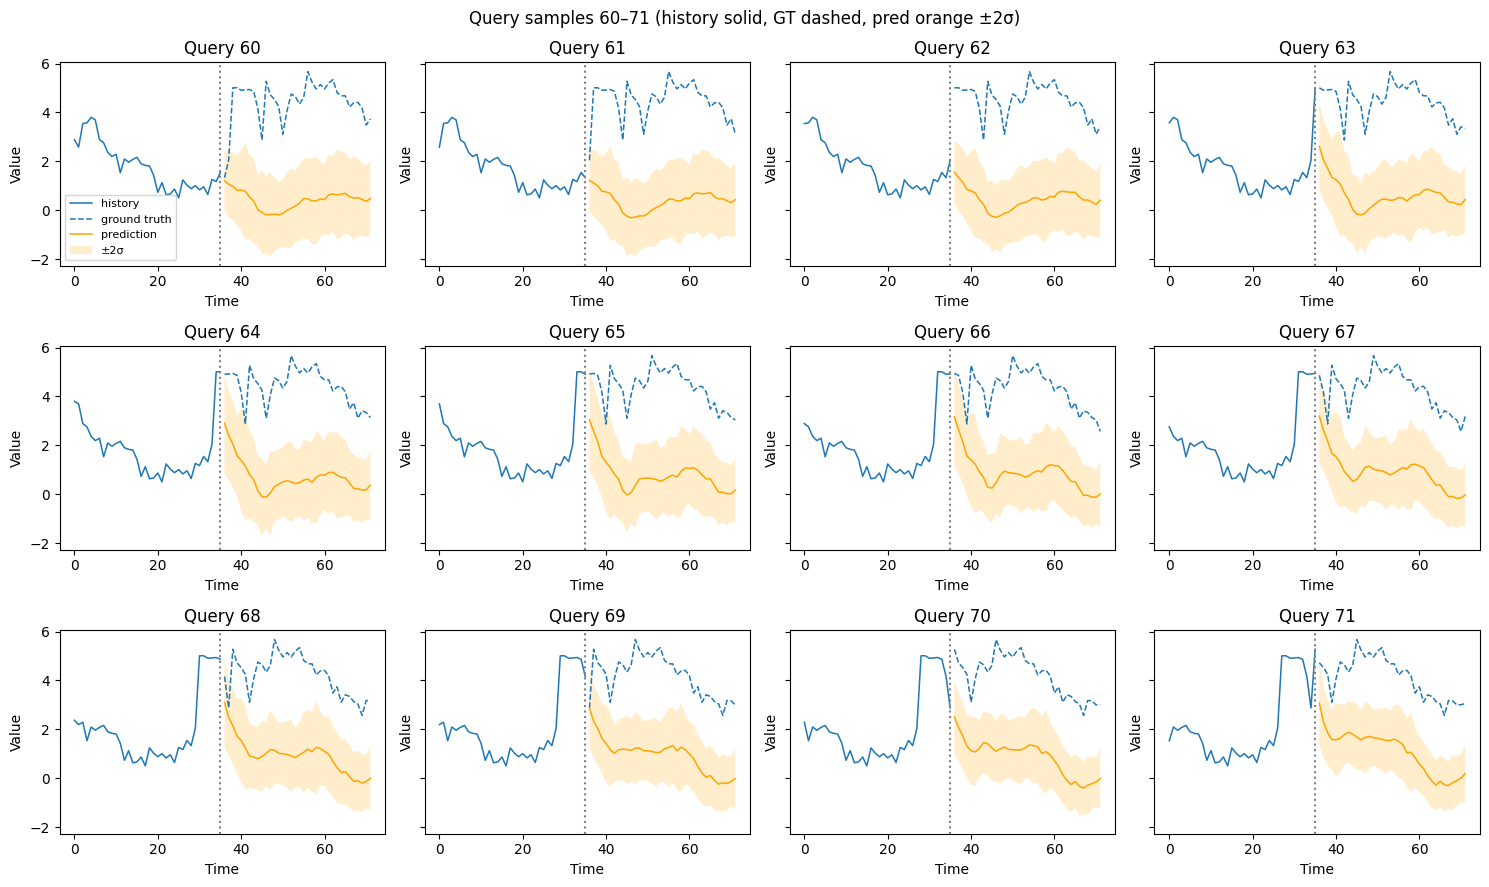

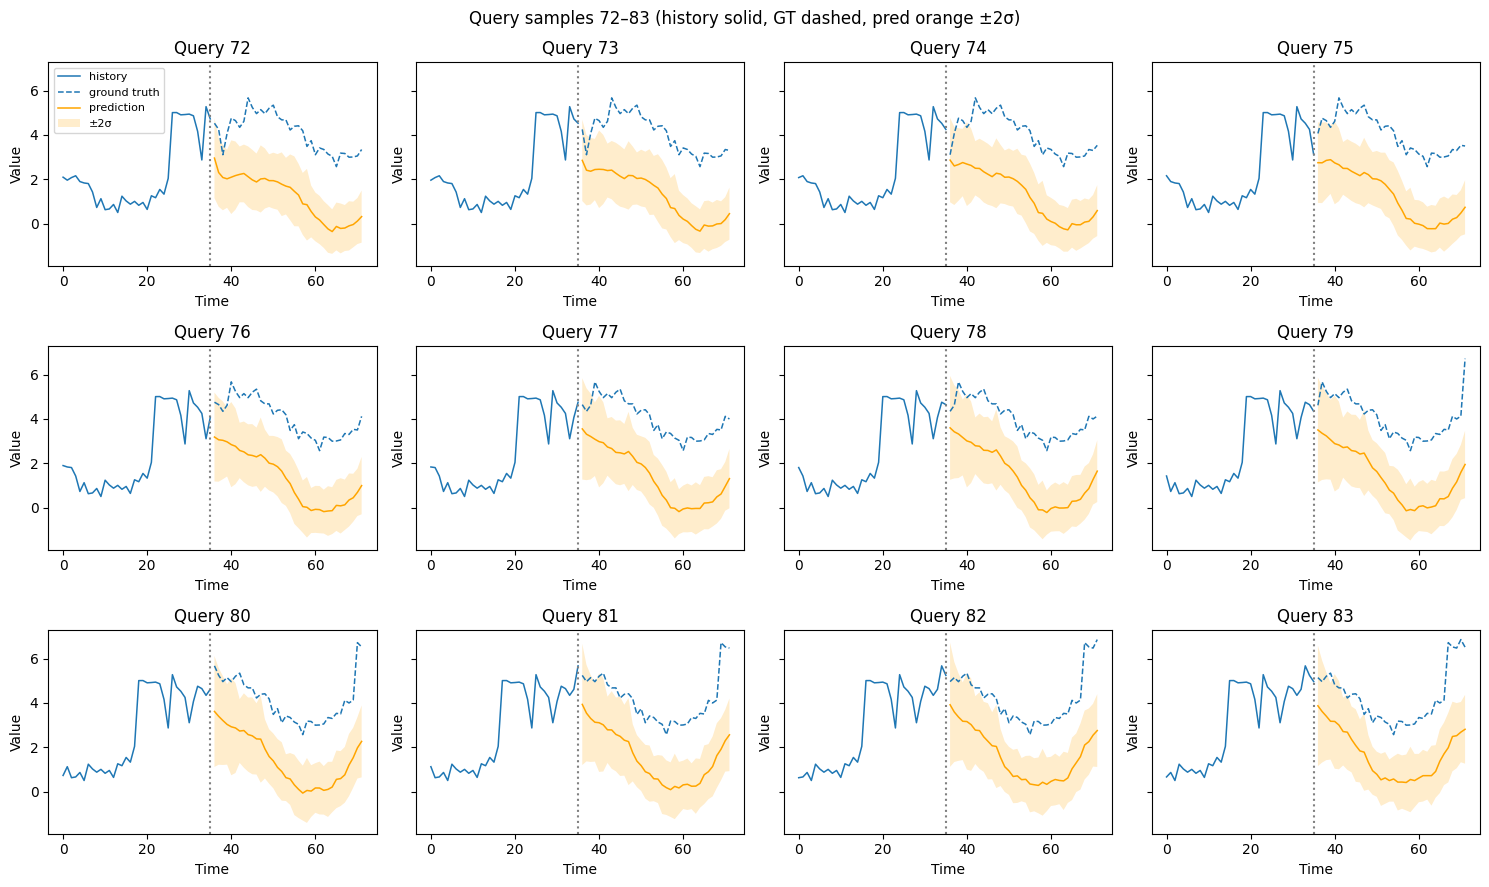

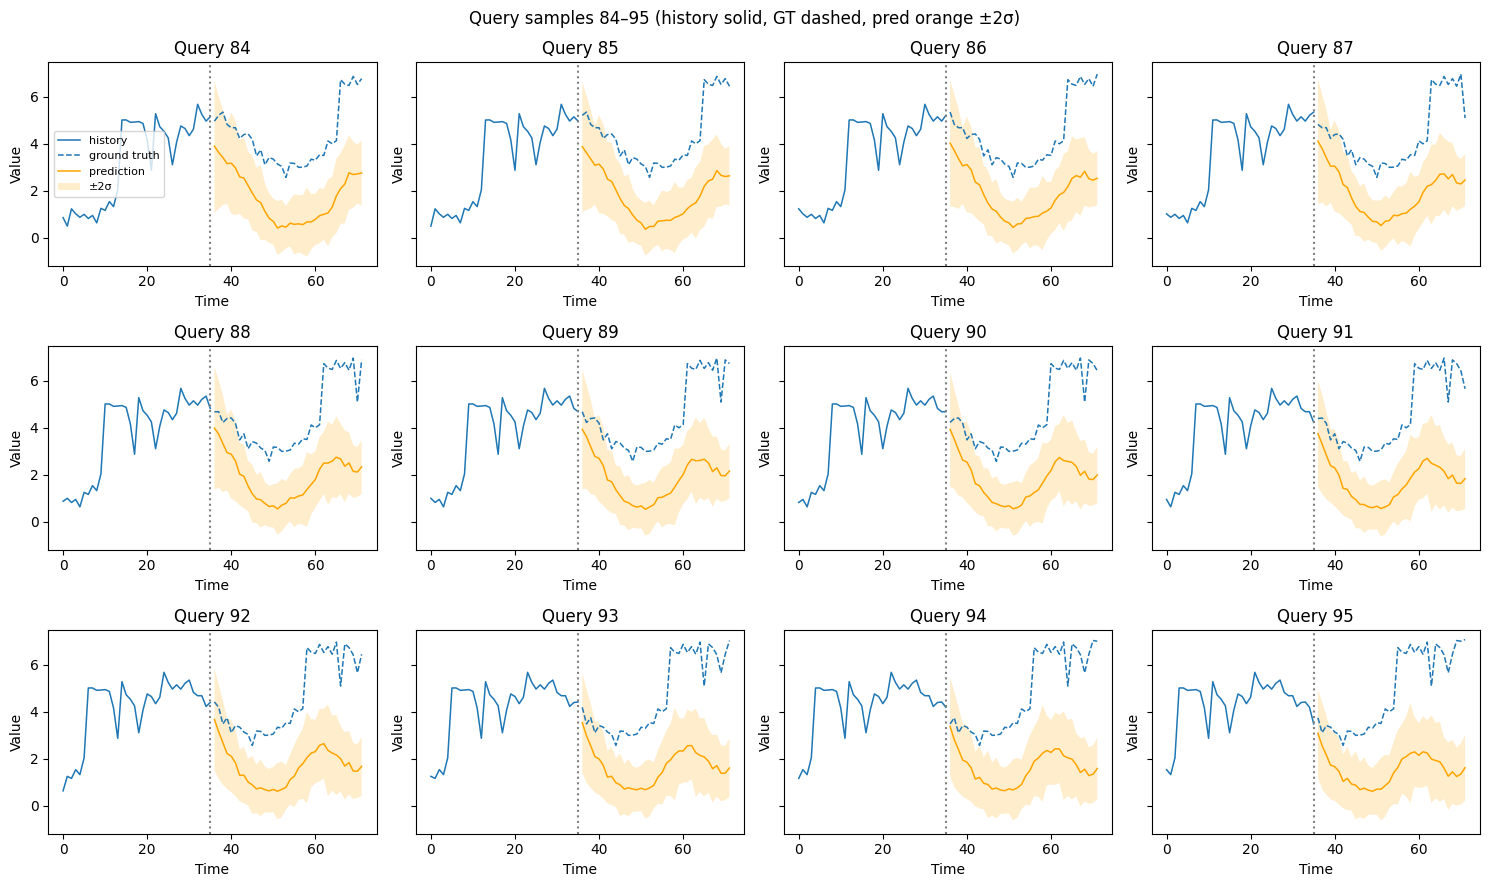

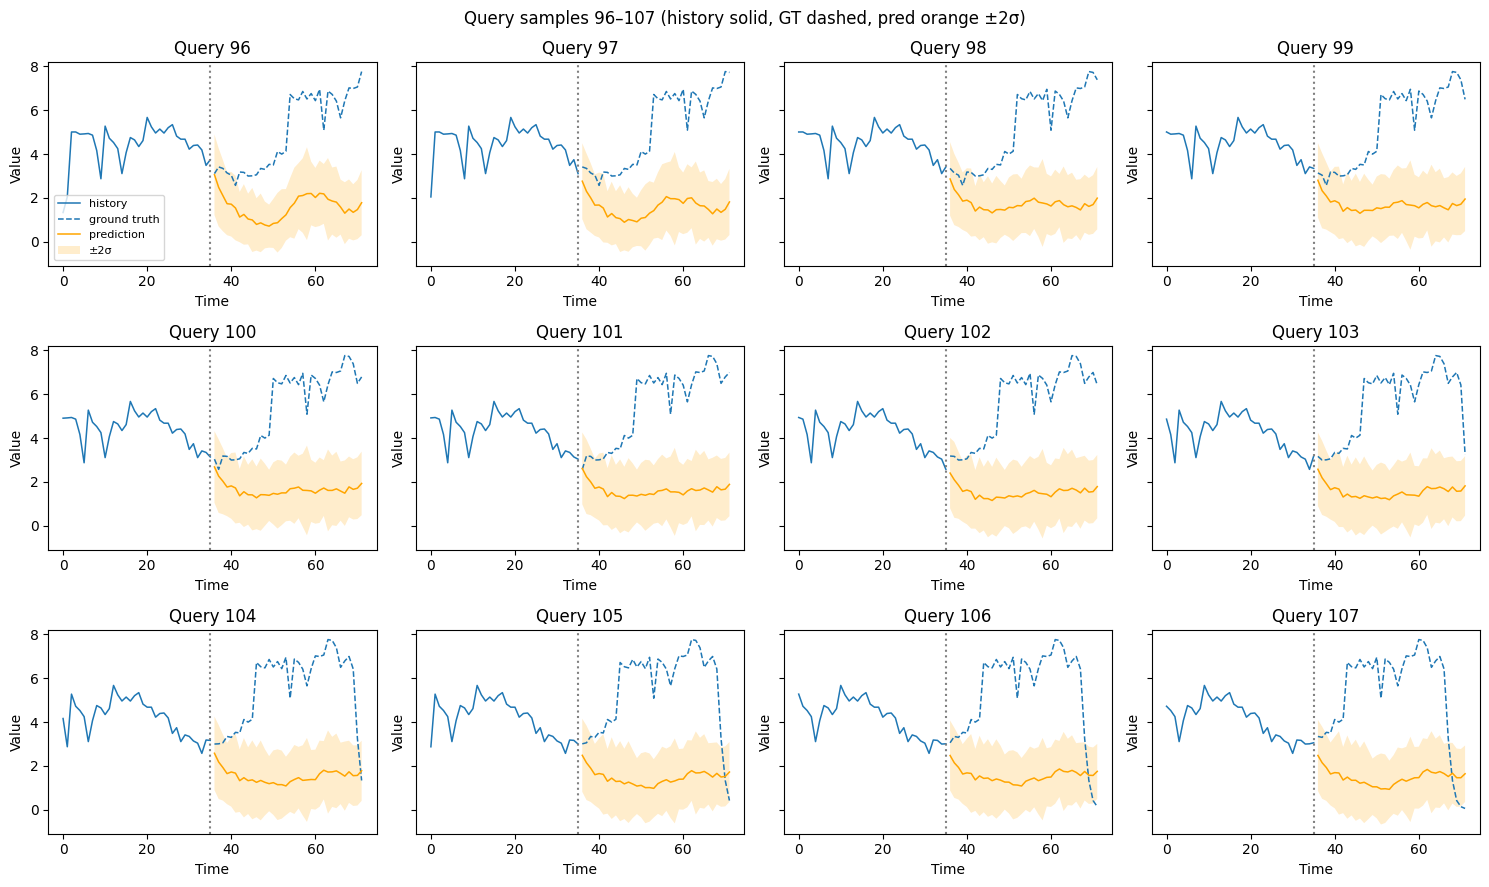

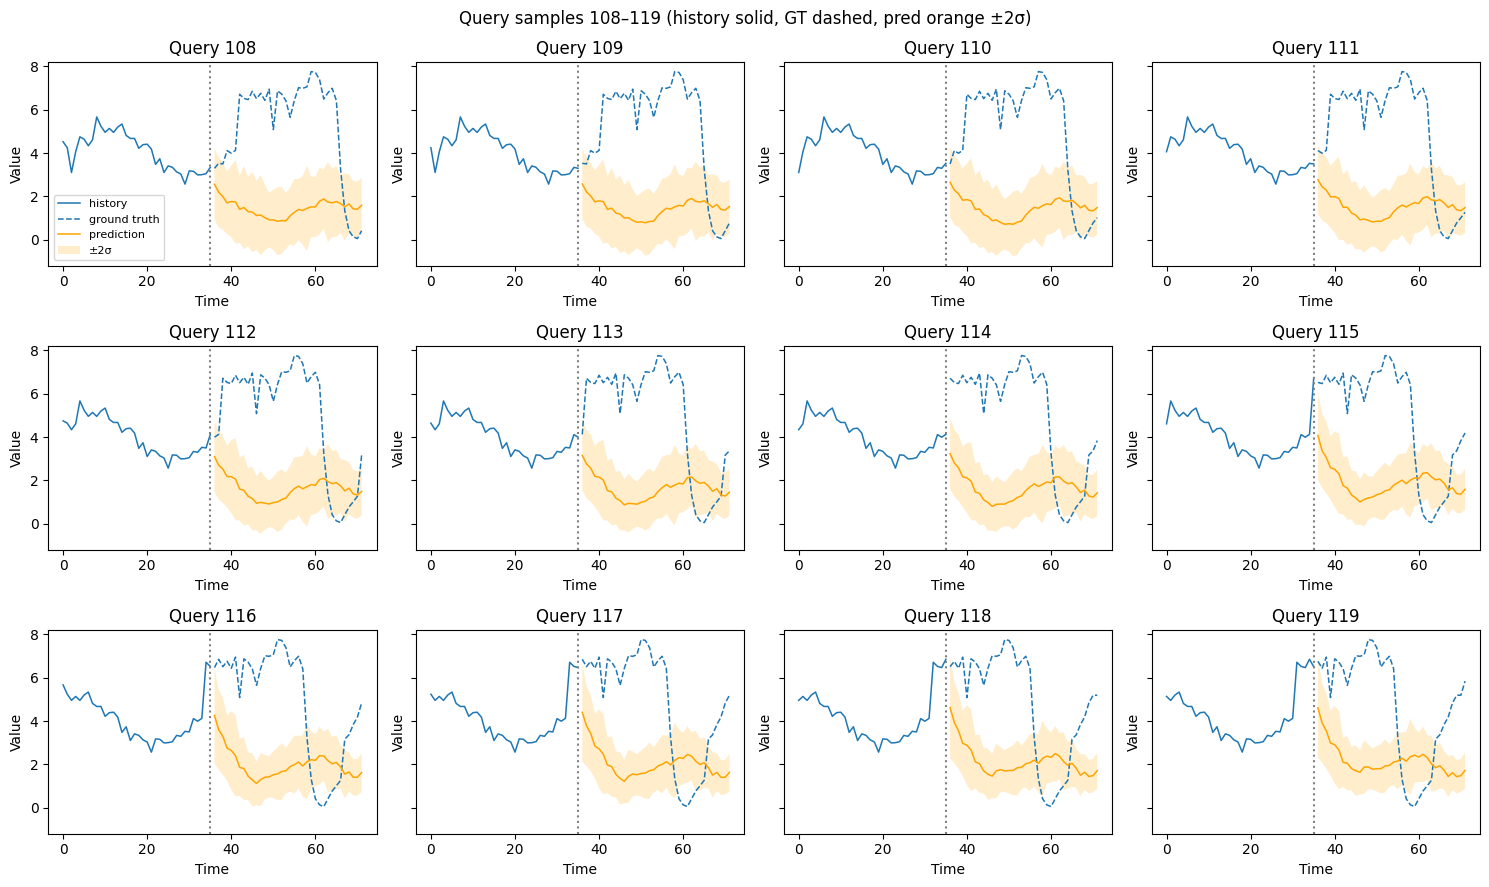

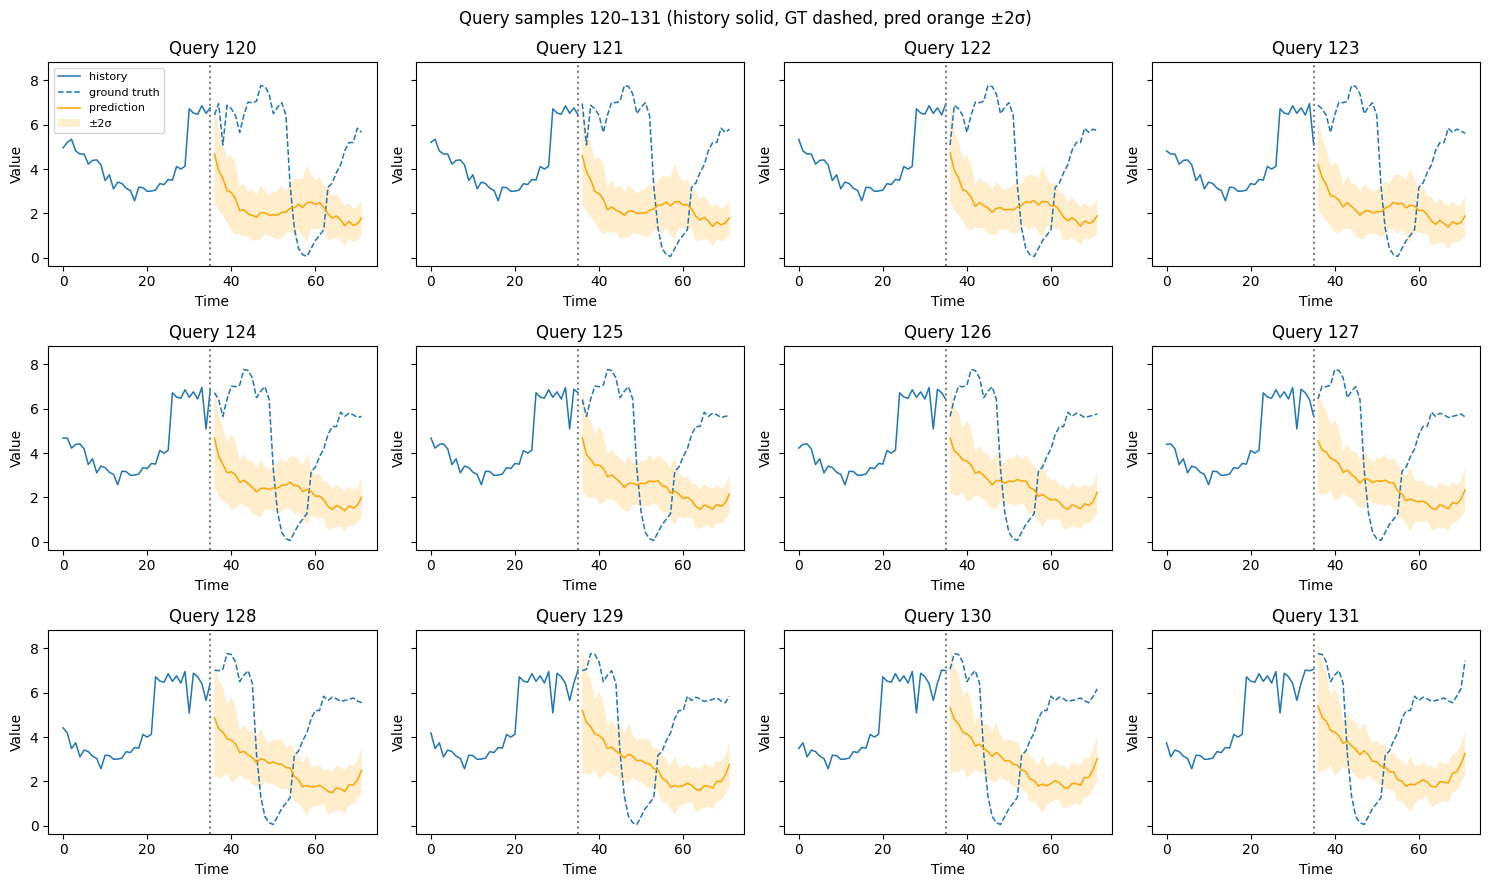

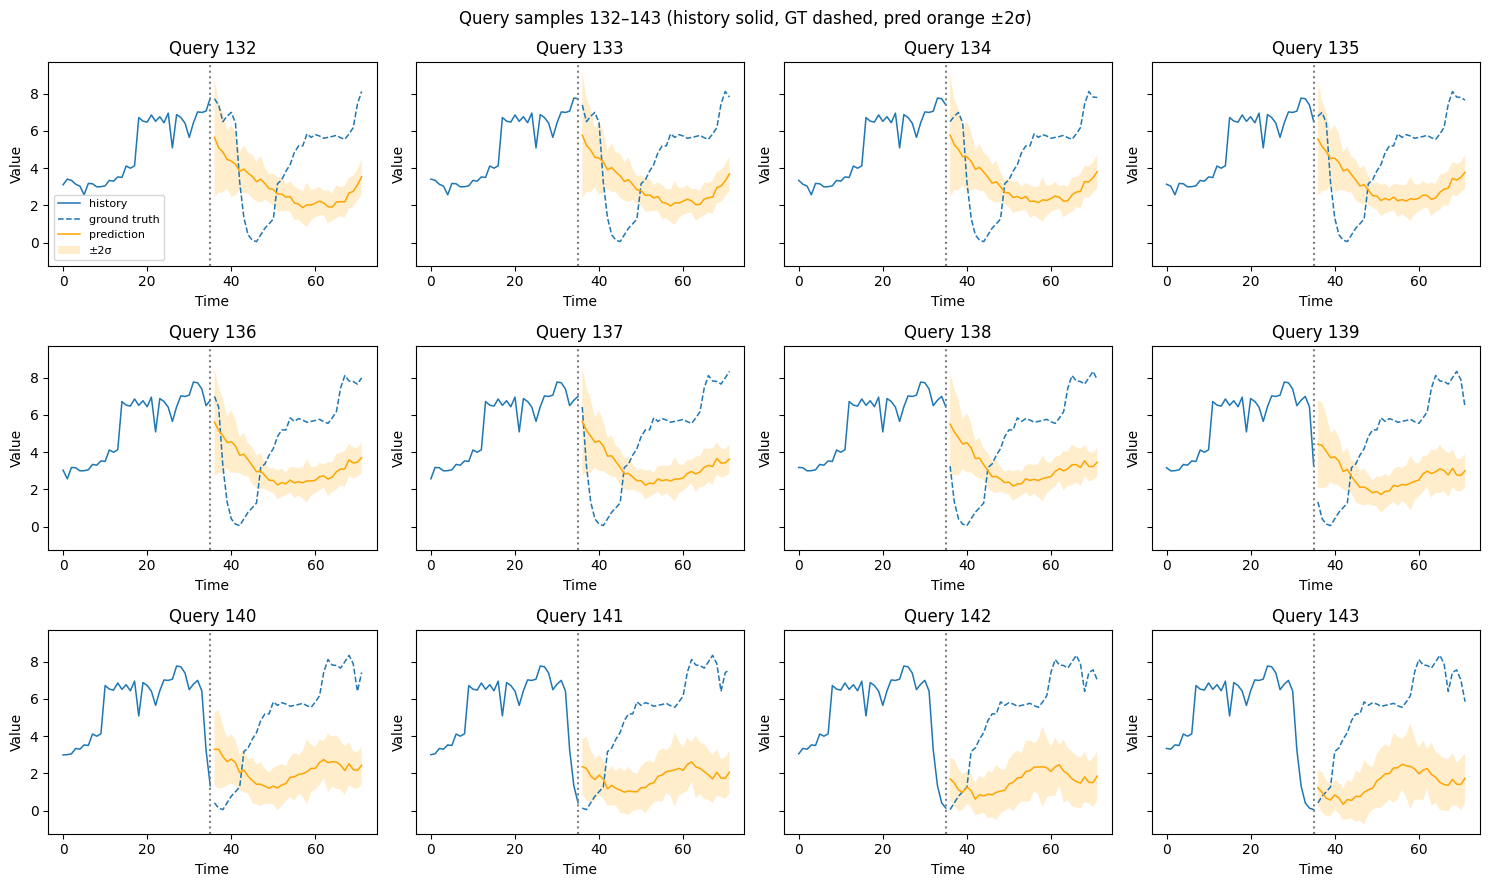

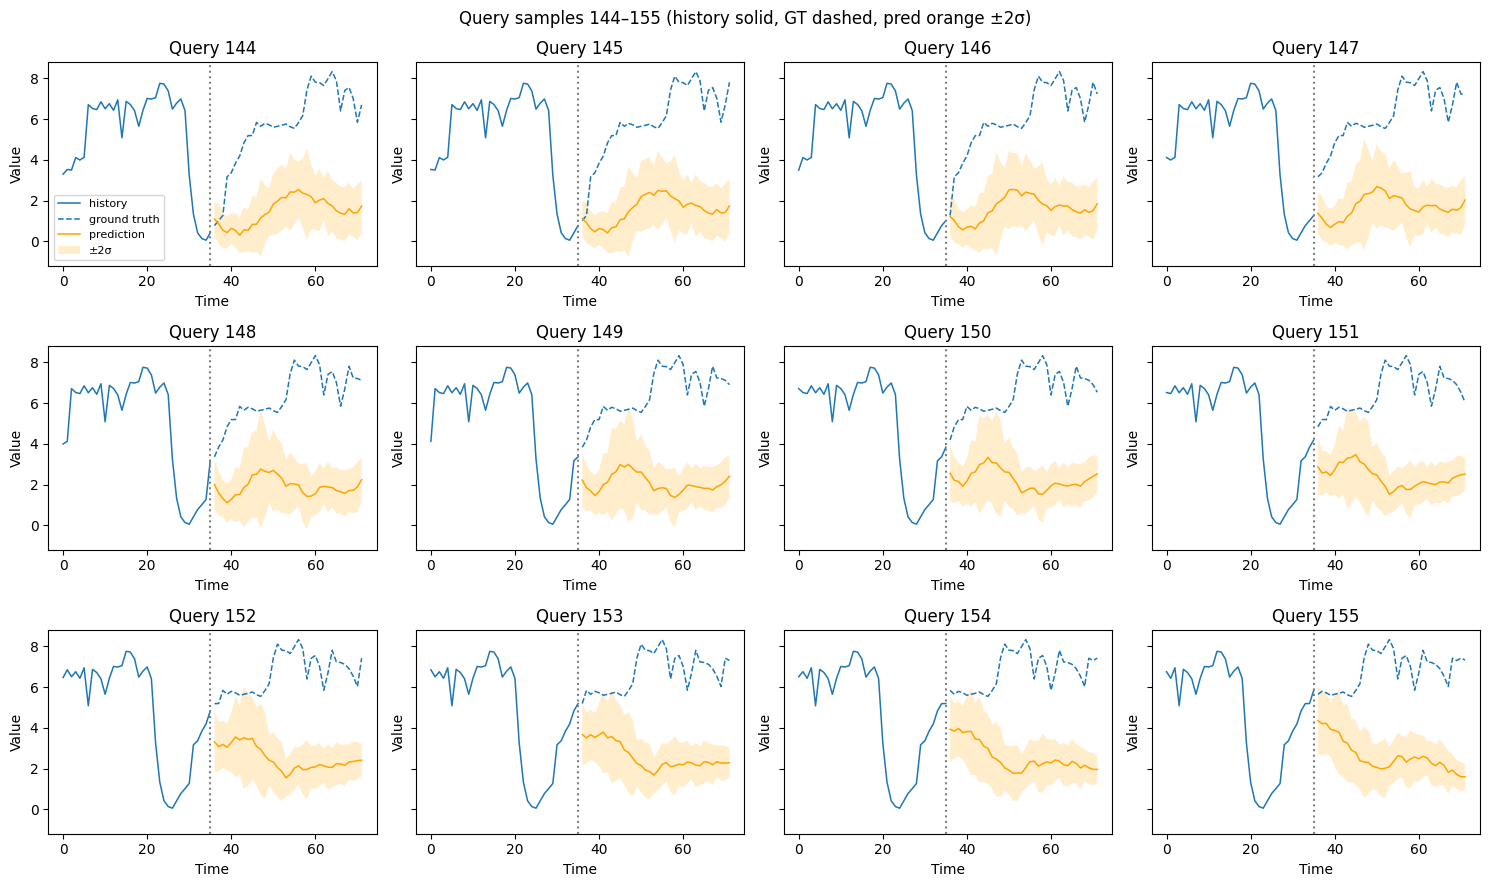

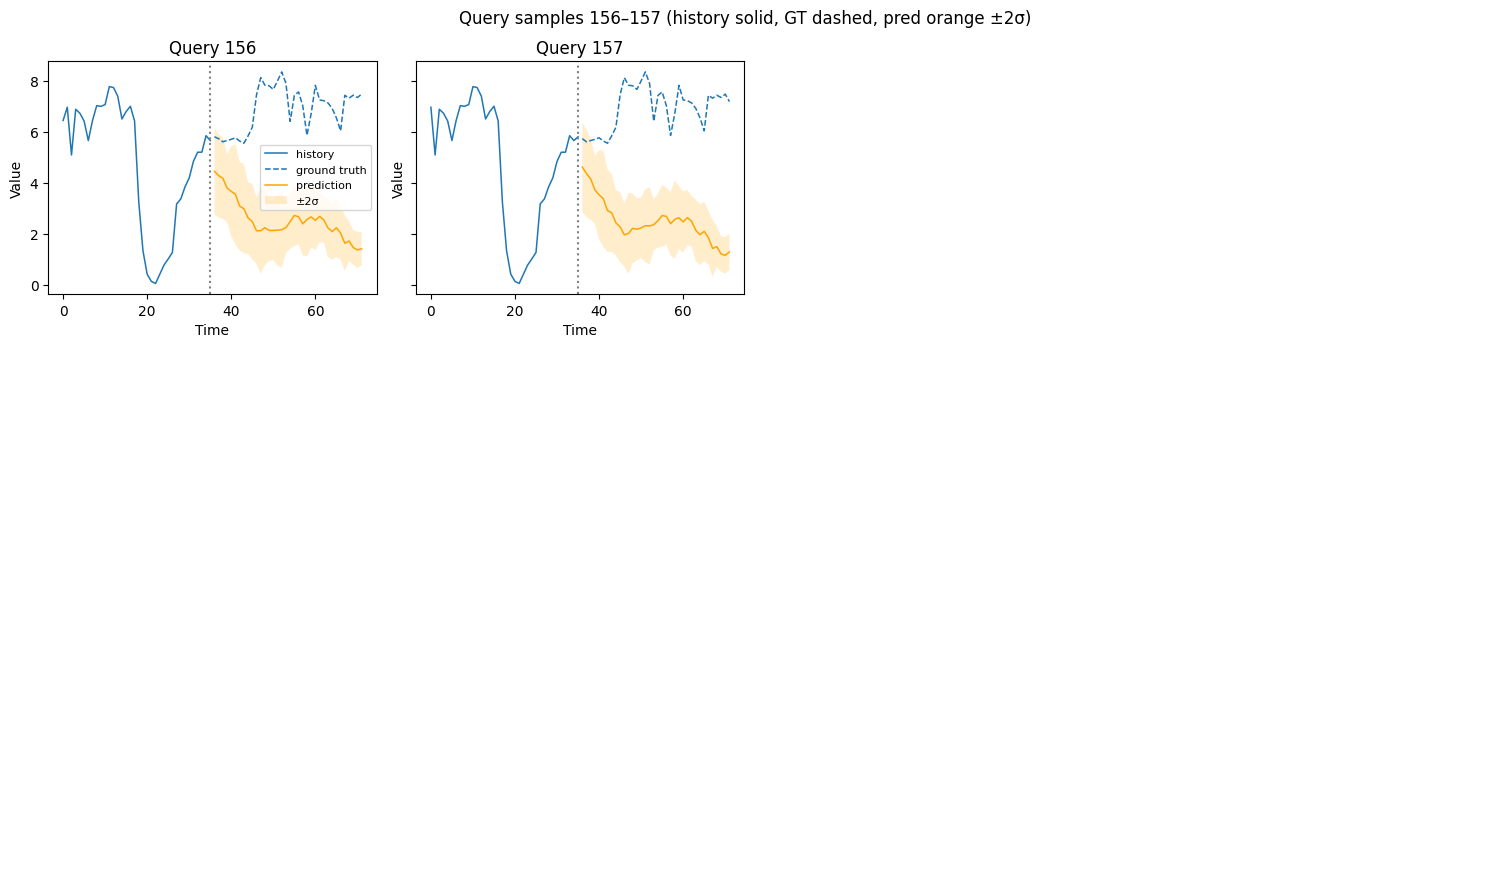

In [10]:
def predict_one(qry_hist_1d):
    # shape to [1, 1, seq_len] and run model with the fixed context set
    q = torch.tensor(qry_hist_1d, dtype=torch.float32, device=device).unsqueeze(0).unsqueeze(0)
    with torch.no_grad():
        out = model(ctx_x_batch, ctx_z_batch, q)
        if isinstance(out, tuple):
            mu, log_sigma2 = out
        else:
            mu, log_sigma2 = out, torch.zeros_like(out)
    mu = mu.squeeze().detach().cpu().numpy()                  # [pred_len]
    std = (log_sigma2.exp().sqrt().squeeze().cpu().numpy())   # [pred_len]
    return mu, std
per_page = 12
rows, cols = 3, 4
Tpred = int(args.pred_len)

for start in range(0, len(test_data), per_page):
    end = min(start+per_page, len(test_data))
    n = end - start
    fig, axes = plt.subplots(rows, cols, figsize=(15, 3*rows), sharey=True)
    axes = axes.ravel()

    for ax, idx in zip(axes, range(start, end)):
        # data
        hist, gt = get_patch(test_data, idx, Tpred)
        t_hist = np.arange(len(hist))
        t_gt   = np.arange(len(hist), len(hist)+len(gt))

        # prediction
        mu, std = predict_one(hist)
        t_mu = t_gt  # same horizon indexing

        # choose a color from current cycle for history/gt pair
        color = next(ax._get_lines.prop_cycler)['color']

        # draw: history (solid), ground-truth horizon (dashed, same color)
        ax.plot(t_hist, hist, lw=1.1, color=color, label="history")
        ax.plot(t_gt,   gt,   lw=1.1, ls="--", color=color, label="ground truth")

        # draw: model mean (orange) + 95% band
        ax.plot(t_mu, mu, lw=1.1, color="orange", label="prediction")
        ax.fill_between(t_mu, mu-2*std, mu+2*std, alpha=0.2, edgecolor="none", facecolor="orange", label="±2σ")

        # splitter
        ax.axvline(len(hist)-1, ls=":", c="gray")
        ax.set_title(f"Query {idx}")
        ax.set_xlabel("Time"); ax.set_ylabel("Value")

        # minimal legend (first few only to save space)
        if idx == start:
            ax.legend(fontsize=8, loc="best")

    # turn off unused axes
    for ax in axes[n:]:
        ax.axis("off")

    plt.suptitle(f"Query samples {start}–{end-1} (history solid, GT dashed, pred orange ±2σ)")
    plt.tight_layout()
    plt.show()